/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


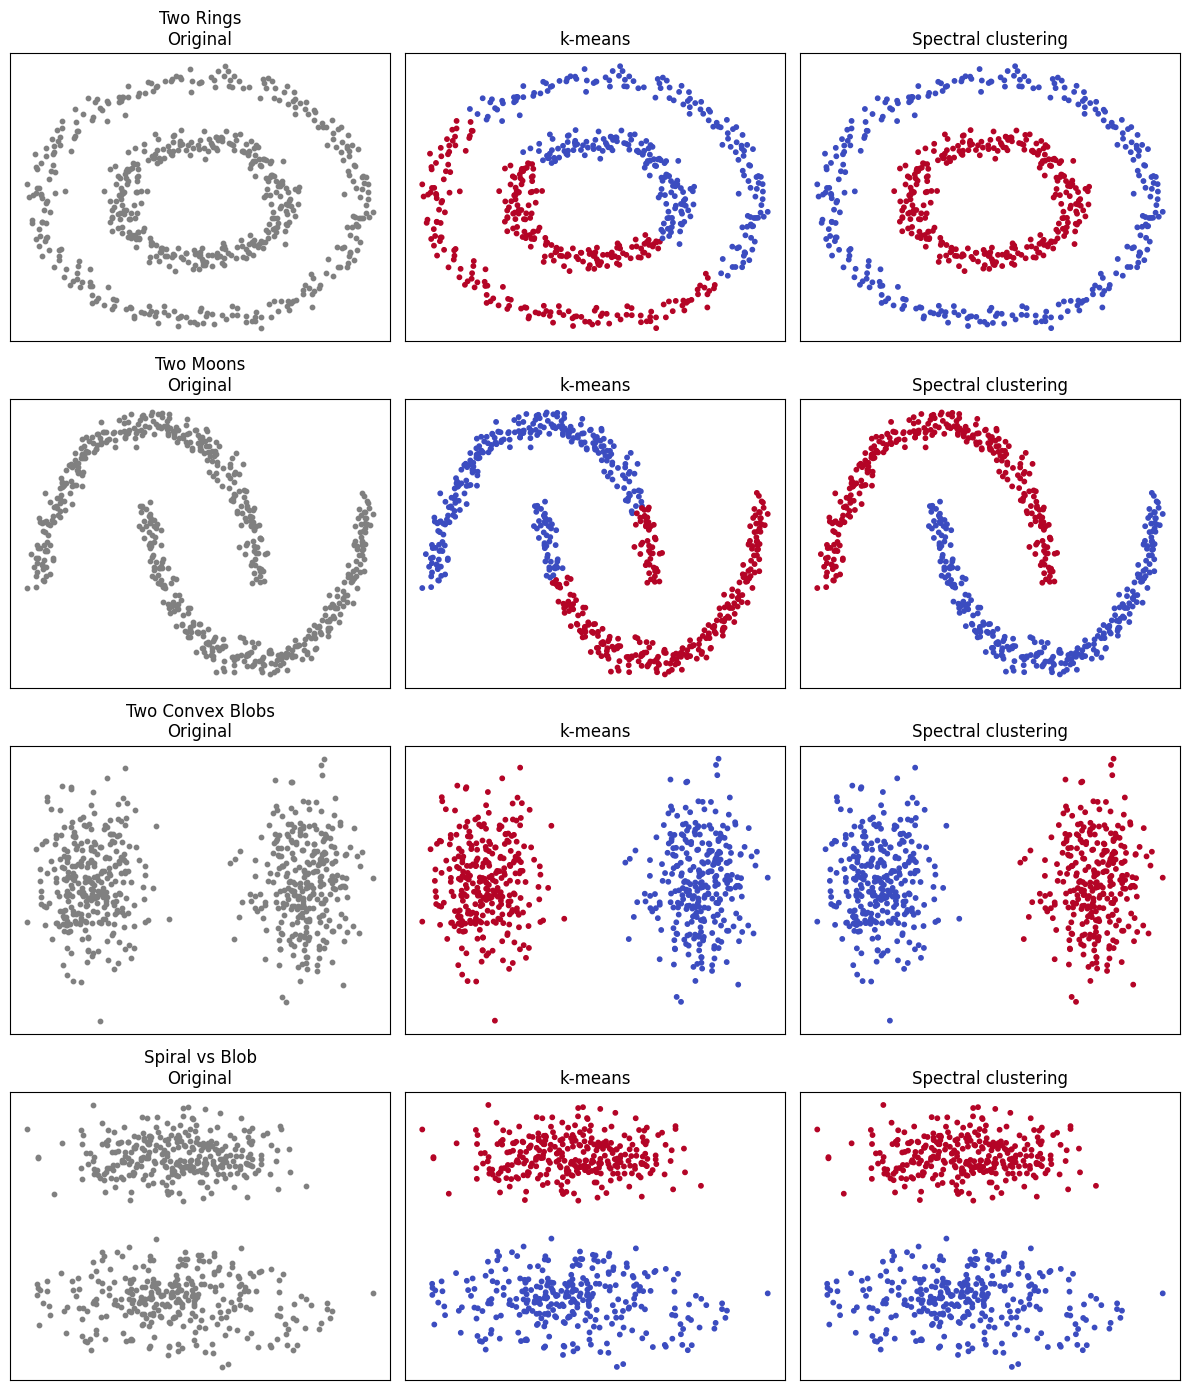

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

# =========================
# DATASETS
# =========================

datasets = []

# 1. Two rings
X, _ = make_circles(n_samples=600, factor=0.5, noise=0.05)
datasets.append(("Two Rings", X))

# 2. Two moons
X, _ = make_moons(n_samples=600, noise=0.05)
datasets.append(("Two Moons", X))

# 3. Two convex blobs
X, _ = make_blobs(
    n_samples=600,
    centers=[[-2, 0], [2, 0]],
    cluster_std=0.5
)
datasets.append(("Two Convex Blobs", X))

# 4. Spiral vs blob (custom)
def spiral_vs_blob(n=300, noise=0.2):
    t = np.linspace(0, 4 * np.pi, n)
    spiral = np.c_[t * np.cos(t), t * np.sin(t)] * 0.1
    spiral += noise * np.random.randn(n, 2)
    blob = np.random.randn(n, 2) * 0.4 + np.array([0, 3])
    return np.vstack([spiral, blob])

X = spiral_vs_blob()
datasets.append(("Spiral vs Blob", X))


# =========================
# PLOTTING
# =========================

fig, axs = plt.subplots(len(datasets), 3, figsize=(12, 14))

for i, (title, X) in enumerate(datasets):
    X = StandardScaler().fit_transform(X)

    # k-means
    km = KMeans(n_clusters=2, n_init=10, random_state=42)
    labels_km = km.fit_predict(X)

    # spectral clustering
    sc = SpectralClustering(
        n_clusters=2,
        affinity="nearest_neighbors",
        n_neighbors=10,
        random_state=42
    )
    labels_sc = sc.fit_predict(X)

    # Original data
    axs[i, 0].scatter(X[:, 0], X[:, 1], s=10, color="gray")
    axs[i, 0].set_title(f"{title}\nOriginal")

    # k-means result
    axs[i, 1].scatter(X[:, 0], X[:, 1], c=labels_km, cmap="coolwarm", s=10)
    axs[i, 1].set_title("k-means")

    # Spectral clustering result
    axs[i, 2].scatter(X[:, 0], X[:, 1], c=labels_sc, cmap="coolwarm", s=10)
    axs[i, 2].set_title("Spectral clustering")

    for j in range(3):
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.tight_layout()
plt.show()

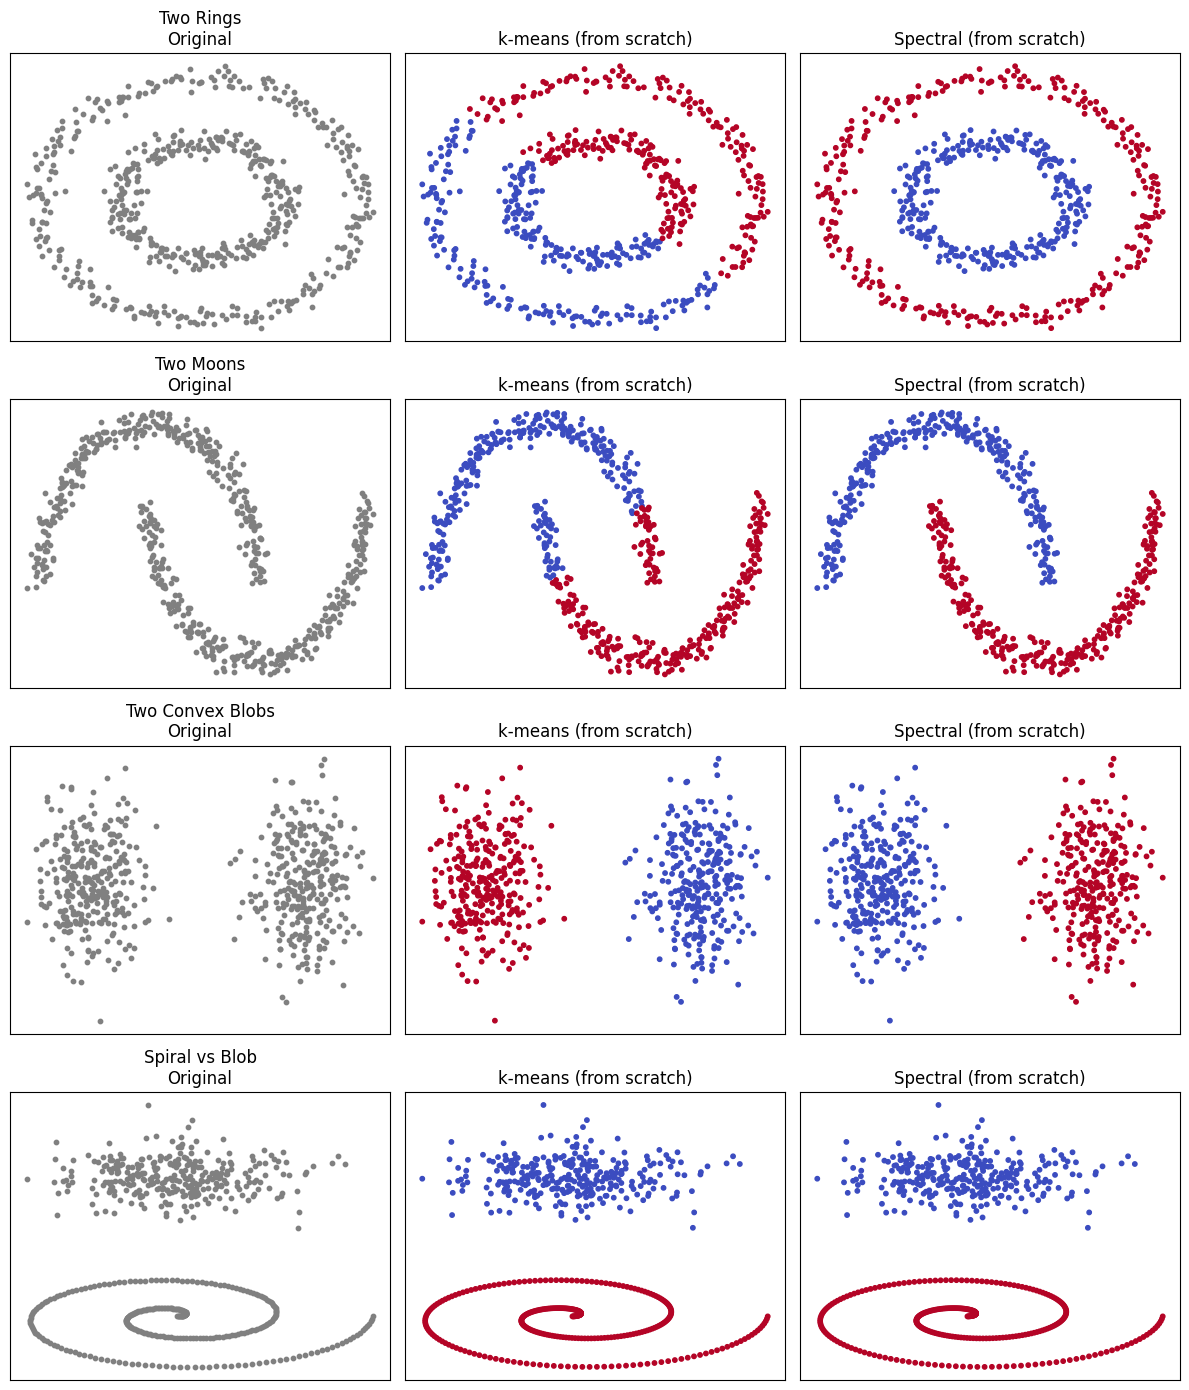

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.preprocessing import StandardScaler

# =========================
# Utils
# =========================
def standardize(X):
    return StandardScaler().fit_transform(X)

# =========================
# k-means (from scratch)
# =========================
def _kmeans_single(X, k, max_iter=300):
    n = X.shape[0]
    centers = X[np.random.choice(n, k, replace=False)]

    for _ in range(max_iter):
        dist = np.linalg.norm(X[:, None] - centers[None, :], axis=2)
        labels = np.argmin(dist, axis=1)

        new_centers = centers.copy()
        for i in range(k):
            pts = X[labels == i]
            if len(pts) > 0:
                new_centers[i] = pts.mean(axis=0)

        if np.allclose(new_centers, centers):
            break
        centers = new_centers

    inertia = ((X - centers[labels])**2).sum()
    return labels, inertia


def kmeans(X, k, n_init=10, random_state=42):
    rng = np.random.default_rng(random_state)
    best_labels, best_inertia = None, None

    for _ in range(n_init):
        np.random.seed(int(rng.integers(0, 1_000_000)))
        labels, inertia = _kmeans_single(X, k)
        if best_inertia is None or inertia < best_inertia:
            best_labels, best_inertia = labels, inertia

    return best_labels

# =========================
# Spectral clustering (from scratch)
# =========================
def knn_connectivity_graph(X, n_neighbors=10):
    n = X.shape[0]
    dists = np.linalg.norm(X[:, None] - X[None, :], axis=2)
    idx = np.argsort(dists, axis=1)[:, 1:n_neighbors+1]

    W = np.zeros((n, n))
    for i in range(n):
        W[i, idx[i]] = 1.0

    return np.maximum(W, W.T)


def spectral_clustering(X, k, n_neighbors=10, n_init=10, random_state=42):
    W = knn_connectivity_graph(X, n_neighbors)
    d = W.sum(axis=1)
    d[d == 0] = 1e-12

    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))
    L_sym = np.eye(len(W)) - D_inv_sqrt @ W @ D_inv_sqrt

    evals, evecs = np.linalg.eigh(L_sym)
    idx = np.argsort(evals)

    U = evecs[:, idx[:k]]
    U /= np.linalg.norm(U, axis=1, keepdims=True) + 1e-12

    return kmeans(U, k, n_init=n_init, random_state=random_state)
дю
# =========================
# Experiments (library datasets)
# =========================
def compare_all():
    np.random.seed(42)

    datasets = [
        ("Two Rings", make_circles(n_samples=600, factor=0.5, noise=0.05)[0]),
        ("Two Moons", make_moons(n_samples=600, noise=0.05)[0]),
        ("Two Convex Blobs",
         make_blobs(n_samples=600, centers=[[-2, 0], [2, 0]], cluster_std=0.5)[0]),
    ]

    # custom dataset (still okay to keep one)
    t = np.linspace(0, 4*np.pi, 300)
    spiral = np.c_[t*np.cos(t), t*np.sin(t)] * 0.1
    blob = np.random.randn(300, 2) * 0.4 + np.array([0, 3])
    datasets.append(("Spiral vs Blob", np.vstack([spiral, blob])))

    fig, axs = plt.subplots(len(datasets), 3, figsize=(12, 14))

    for i, (name, X) in enumerate(datasets):
        Xs = standardize(X)

        labels_km = kmeans(Xs, 2, n_init=10)
        labels_sc = spectral_clustering(Xs, 2, n_neighbors=10, n_init=10)

        axs[i, 0].scatter(Xs[:, 0], Xs[:, 1], s=10, color="gray")
        axs[i, 0].set_title(f"{name}\nOriginal")

        axs[i, 1].scatter(Xs[:, 0], Xs[:, 1], c=labels_km, s=10, cmap="coolwarm")
        axs[i, 1].set_title("k-means (from scratch)")

        axs[i, 2].scatter(Xs[:, 0], Xs[:, 1], c=labels_sc, s=10, cmap="coolwarm")
        axs[i, 2].set_title("Spectral (from scratch)")

        for j in range(3):
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])

    plt.tight_layout()
    plt.show()


# Запуск
compare_all()